# Part B

# imports

In [ ]:

import os
import shutil
import time
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.utils.prune as prune
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments


# **Models**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = '/content/drive/MyDrive/NLP_project/trained_model'
model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(model_path)

In [ ]:


# Verify GPU availability
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

# Define text cleaner function
def text_cleaner(text):
    # Lowercase the text
    text = text.lower()

    # Replace URLs with _url_
    text = re.sub(r'https?://\S+|www\.\S+', '_url_', text)

    # Replace emails with _email_
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '_email_', text)

    # Remove special characters except ', ", _url_, and _email_
    text = re.sub(r"[^a-zA-Z0-9\s'\"_]", '', text)

    # Remove sequences of underscores that are not _url_ or _email_
    def clean_underscores(match):
        text = match.group(0)
        if text in ['_url_', '_email_']:
            return text
        return text.replace('_', '')

    text = re.sub(r'\b_[a-zA-Z0-9_]*_\b', clean_underscores, text)

    # Replace sequences of whitespace with a single space
    text = re.sub(r'\s+', ' ', text)

    # Strip leading and trailing whitespace
    text = text.strip()

    return text

# Load data
df = pd.read_csv('/content/drive/MyDrive/NLP_project/phishing_data/phishing_email.csv')
df.dropna(inplace=True)

# Clean the email texts
df['text_combined'] = df['text_combined'].apply(text_cleaner)

# Ensure labels are integers
df['label'] = df['label'].astype(int)

class EmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
def get_predictions(model, dataloader):
    model.eval()
    predictions = []
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    device = 'cpu'
    model.to(device)
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            batch_predictions = torch.argmax(logits, dim=-1)
            predictions.extend(batch_predictions.cpu().numpy())

    return predictions
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text_combined'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)
train_dataset = EmailDataset(train_texts, train_labels, tokenizer, max_len=512)
val_dataset = EmailDataset(val_texts, val_labels, tokenizer, max_len=512)
data_set = EmailDataset(df['text_combined'].tolist(), df['label'].tolist(), tokenizer, max_len=512)
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
def print_model_parameters(model):
    """
    Print the number of trainable parameters in the model.

    :param model: The model to evaluate.
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params}")

def print_size_of_model(model):
    """
    Print the size of the model by saving it temporarily.

    :param model: The model to evaluate.
    """
    torch.save(model.state_dict(), "temp.pth")
    size = os.path.getsize("temp.pth") / (1024 ** 2)
    print(f"Model size: {size:.2f} MB")
    os.remove("temp.pth")



CUDA available: True
Number of GPUs: 1
GPU Name: NVIDIA A100-SXM4-40GB


##**Roberta For Sequence Classification**

In [ ]:
#!pip install --upgrade numpy


In [ ]:
# Load tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Define compute_metrics function to calculate accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# Create a PyTorch dataset
class EmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Split dataset with a fixed random seed
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text_combined'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)
train_dataset = EmailDataset(train_texts, train_labels, tokenizer, max_len=512)
val_dataset = EmailDataset(val_texts, val_labels, tokenizer, max_len=512)

# Check if a GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define training arguments with matching save and eval strategies
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,  # Increased batch size for efficiency
    per_device_eval_batch_size=16,
    warmup_steps=100,  # Reduced warmup steps
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,  # Log every 100 steps
    evaluation_strategy="epoch",  # Evaluate only at the end of each epoch
    save_strategy="epoch",  # Save model only at the end of each epoch
    load_best_model_at_end=True,  # Load the best model at the end of training
    fp16=True,  # Enable mixed precision training for faster GPU training
)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
training_output = trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(f"Validation Loss: {results['eval_loss']}")
print(f"Validation Accuracy: {results['eval_accuracy'] * 100:.2f}%")

# Save the trained model and tokenizer after training completes
model.save_pretrained('/content/drive/MyDrive/NLP_project/trained_model')
tokenizer.save_pretrained('/content/drive/MyDrive/NLP_project/trained_model')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.154800,0.089579,0.976724
2,0.045100,0.064548,0.986908
3,0.038100,0.047741,0.989756


Validation Loss: 0.04774054139852524
Validation Accuracy: 98.98%


('/content/drive/MyDrive/NLP_project/trained_model/tokenizer_config.json',
 '/content/drive/MyDrive/NLP_project/trained_model/special_tokens_map.json',
 '/content/drive/MyDrive/NLP_project/trained_model/vocab.json',
 '/content/drive/MyDrive/NLP_project/trained_model/merges.txt',
 '/content/drive/MyDrive/NLP_project/trained_model/added_tokens.json')

In [ ]:
# Save the trained model's weights
model.save_pretrained('./trained_model')
# Optionally, save the tokenizer as well
tokenizer.save_pretrained('./trained_model')

('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/vocab.json',
 './trained_model/merges.txt',
 './trained_model/added_tokens.json')

## **Bert For Sequence Classification**

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define compute_metrics function to calculate accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# Create a PyTorch dataset
class EmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



# Create dataset and dataloader
dataset = EmailDataset(df['text_combined'].tolist(), df['label'].tolist(), tokenizer, max_len=512)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Check if a GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Move the model to the GPU if available
model.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    fp16=True,  # Enable mixed precision training for faster GPU training
)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
training_output = trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(f"Validation Loss: {results['eval_loss']}")
print(f"Validation Accuracy: {results['eval_accuracy'] * 100:.2f}%")
model.save_pretrained('/content/drive/MyDrive/NLP_project/trained_modelbert')
tokenizer.save_pretrained('/content/drive/MyDrive/NLP_project/trained_modelbert')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.075000,0.043093,0.991635


Epoch,Training Loss,Validation Loss,Accuracy
1,0.075000,0.043093,0.991635
2,0.000200,0.032045,0.994181
3,0.000100,0.033964,0.995575


Validation Loss: 0.0339641198515892
Validation Accuracy: 99.56%


('/content/drive/MyDrive/NLP_project/trained_modelbert/tokenizer_config.json',
 '/content/drive/MyDrive/NLP_project/trained_modelbert/special_tokens_map.json',
 '/content/drive/MyDrive/NLP_project/trained_modelbert/vocab.txt',
 '/content/drive/MyDrive/NLP_project/trained_modelbert/added_tokens.json')

# Model compression

In [ ]:
# %pip install optimum[onnxruntime]


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

inference roberta

In [ ]:
#Roberta
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
trainer.model = model
results = trainer.evaluate()
print(f"Validation Loss: {results['eval_loss']}")
print(f"Validation Accuracy: {results['eval_accuracy'] * 100:.2f}%")

Validation Loss: 0.04774187132716179
Validation Accuracy: 98.98%


In [ ]:
def print_size_of_model(model):
    """
    Print the size of the model by saving it temporarily.

    :param model: The model to evaluate.
    """
    torch.save(model.state_dict(), "temp.pth")
    size = os.path.getsize("temp.pth") / (1024 ** 2)
    print(f"Model size: {size:.2f} MB")
    os.remove("temp.pth")


## **Quantization**

In [ ]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params

    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")
    print(f"Non-trainable parameters: {non_trainable_params}")




In [ ]:



model_path = '/content/drive/MyDrive/NLP_project/trained_model'
model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(model_path)
# Define the quantization configuration
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)


print_size_of_model(model)
print_size_of_model(quantized_model)


from torch.utils.data import DataLoader
from tqdm import tqdm
import time

def evaluate_model(model, val_dataset, batch_size=8):
    # Put model in evaluation mode
    model.eval()

    # Prepare DataLoader
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    total_correct = 0
    total_samples = 0
    inference_times = []

    with torch.no_grad():
        for batch in tqdm(val_loader):
            # Measure inference time
            start_time = time.time()

            # Move inputs to device
            input_ids = batch['input_ids'].to(model.device)
            attention_mask = batch['attention_mask'].to(model.device)
            labels = batch['labels'].to(model.device)

            # Perform forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Measure end time
            end_time = time.time()

            # Calculate time taken for inference
            inference_times.append(end_time - start_time)

            # Get the predicted classes
            predictions = torch.argmax(outputs.logits, dim=-1)

            # Update total correct and total samples
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate accuracy
    accuracy = total_correct / total_samples

    # Calculate average inference time per batch
    avg_inference_time = sum(inference_times) / len(inference_times)

    return accuracy, avg_inference_time
# Assuming val_dataset is already tokenized and ready
accuracy, avg_inference_time = evaluate_model(quantized_model, val_dataset)

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Average Inference Time per Batch: {avg_inference_time:.4f} seconds')


Size (MB): 498.655353
Size (MB): 242.135253


100%|██████████| 2063/2063 [1:11:05<00:00,  2.07s/it]

Validation Accuracy: 0.9888
Average Inference Time per Batch: 2.0464 seconds


## Pruning

In [ ]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Function to prune the model
def prune_model(model, amount=0.2):
    """
    Apply structured pruning to all applicable layers of the model except the final classifier.
    :param model: The model to be pruned.
    :param amount: The proportion of parameters to prune.
    :return: The pruned model.
    """
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear) and "classifier" not in name:
            prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0)
            prune.remove(module, 'weight')  # Apply pruning and remove reparameterization

        if isinstance(module, nn.Embedding):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')

        if hasattr(module, 'bias') and module.bias is not None:
            prune.l1_unstructured(module, name='bias', amount=amount)
            prune.remove(module, 'bias')

    return model

# Prune the model
pruned_model = prune_model(model)
pruned_model.to(device)

# Update the Trainer with the pruned model (replace with your actual trainer initialization code)
trainer.model = pruned_model

# Evaluate the pruned model
pruned_results = trainer.evaluate()
print(f"Pruned Model - Validation Loss: {pruned_results['eval_loss']}")
print(f"Pruned Model - Validation Accuracy: {pruned_results['eval_accuracy'] * 100:.2f}%")



Pruned Model - Validation Loss: 0.07801347970962524
Pruned Model - Validation Accuracy: 97.93%


In [ ]:
# Function to count zero weights in the model
def count_zero_weights(model):
    zero_weights = 0
    total_weights = 0
    for name, param in model.named_parameters():
        if "weight" in name:
            zero_weights += torch.sum(param == 0).item()
            total_weights += param.nelement()
    return zero_weights, total_weights

# Prune the model
model_path = '/content/drive/MyDrive/trained_model'
model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(model_path)
# Count zero weights in the pruned model
zero_weights, total_weights = count_zero_weights(model)
print(f"Number of zero weights: {zero_weights} / {total_weights} ({(zero_weights / total_weights) * 100:.2f}% sparsity)")

print("--------------------------------------------------------------------")

zero_weights, total_weights = count_zero_weights(pruned_model)
print(f"Number of zero weights: {zero_weights} / {total_weights} ({(zero_weights / total_weights) * 100:.2f}% sparsity)")


Number of zero weights: 773 / 124544256 (0.00% sparsity)
--------------------------------------------------------------------
Number of zero weights: 24812544 / 124544256 (19.92% sparsity)


In [ ]:
def print_model_parameters(model):
    """
    Print the total number of trainable parameters and the number of non-zero parameters in the model.

    :param model: The model to evaluate.
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_zero_params = sum(torch.sum(p != 0).item() for p in model.parameters() if p.requires_grad)
    zero_params = total_params - non_zero_params

    print(f"Total parameters: {total_params}")
    print(f"Non-zero parameters: {non_zero_params}")
    print(f"Zero parameters: {zero_params}")
    print(f"Model sparsity: {(zero_params / total_params) * 100:.2f}%")

# Prune the model

# Print model parameters
print("Prune model")
print_model_parameters(pruned_model)
print("--------------------------------------")
print("Original model")
model_path = '/content/drive/MyDrive/trained_model'
model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(model_path)

print_model_parameters(model)


Prune model
Total parameters: 124647170
Non-zero parameters: 99814014
Zero parameters: 24833156
Model sparsity: 19.92%
--------------------------------------
Original model
Total parameters: 124647170
Non-zero parameters: 124646397
Zero parameters: 773
Model sparsity: 0.00%


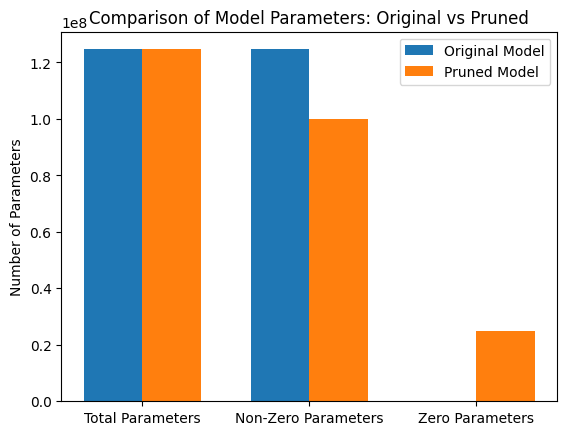

In [ ]:


def get_model_parameters(model):
    """
    Get the total number of trainable parameters, non-zero parameters, and zero parameters in the model.

    :param model: The model to evaluate.
    :return: A tuple containing (total_params, non_zero_params, zero_params).
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_zero_params = sum(torch.sum(p != 0).item() for p in model.parameters() if p.requires_grad)
    zero_params = total_params - non_zero_params
    return total_params, non_zero_params, zero_params

def plot_parameters_comparison(original_params, pruned_params):
    """
    Plot a comparison of total, non-zero, and zero parameters between the original and pruned models.

    :param original_params: A tuple containing (total_params, non_zero_params, zero_params) for the original model.
    :param pruned_params: A tuple containing (total_params, non_zero_params, zero_params) for the pruned model.
    """
    labels = ['Total Parameters', 'Non-Zero Parameters', 'Zero Parameters']
    original_values = [original_params[0], original_params[1], original_params[2]]
    pruned_values = [pruned_params[0], pruned_params[1], pruned_params[2]]

    x = range(len(labels))
    width = 0.35  # Width of the bars

    fig, ax = plt.subplots()
    ax.bar(x, original_values, width, label='Original Model')
    ax.bar([p + width for p in x], pruned_values, width, label='Pruned Model')

    ax.set_ylabel('Number of Parameters')
    ax.set_title('Comparison of Model Parameters: Original vs Pruned')
    ax.set_xticks([p + width / 2 for p in x])
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

# Load the original model
model_path = '/content/drive/MyDrive/trained_model'
original_model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(model_path)

# Get parameters for the original model
original_params = get_model_parameters(original_model)


# Get parameters for the pruned model
pruned_params = get_model_parameters(pruned_model)

# Plot the comparison
plot_parameters_comparison(original_params, pruned_params)


In [ ]:

def print_model_parameters_by_layer(model):
    """
    Print the total number of trainable parameters and the number of non-zero parameters in each layer of the model.

    :param model: The model to evaluate.
    """
    total_params = 0
    non_zero_params = 0
    zero_params = 0

    for name, param in model.named_parameters():
        if param.requires_grad:
            layer_total = param.numel()
            layer_non_zero = torch.sum(param != 0).item()
            layer_zero = layer_total - layer_non_zero

            total_params += layer_total
            non_zero_params += layer_non_zero
            zero_params += layer_zero

            print(f"Layer: {name}")
            print(f"  Total parameters: {layer_total}")
            print(f"  Non-zero parameters: {layer_non_zero}")
            print(f"  Zero parameters: {layer_zero}")
            print(f"  Layer sparsity: {(layer_zero / layer_total) * 100:.2f}%")
            print("--------------------------------------------------")

    print("Summary for the entire model:")
    print(f"Total parameters: {total_params}")
    print(f"Non-zero parameters: {non_zero_params}")
    print(f"Zero parameters: {zero_params}")
    print(f"Model sparsity: {(zero_params / total_params) * 100:.2f}%")

# Example usage:

# Assume pruned_model is the pruned model and model_path is the path to the original model

print("Pruned Model:")
print_model_parameters_by_layer(pruned_model)
print("--------------------------------------")

# Load the original model
model_path = '/content/drive/MyDrive/trained_model'
model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(model_path)

print("Original Model:")
print_model_parameters_by_layer(model)


Pruned Model:
Layer: roberta.embeddings.word_embeddings.weight
  Total parameters: 38603520
  Non-zero parameters: 30882816
  Zero parameters: 7720704
  Layer sparsity: 20.00%
--------------------------------------------------
Layer: roberta.embeddings.position_embeddings.weight
  Total parameters: 394752
  Non-zero parameters: 315802
  Zero parameters: 78950
  Layer sparsity: 20.00%
--------------------------------------------------
Layer: roberta.embeddings.token_type_embeddings.weight
  Total parameters: 768
  Non-zero parameters: 614
  Zero parameters: 154
  Layer sparsity: 20.05%
--------------------------------------------------
Layer: roberta.embeddings.LayerNorm.weight
  Total parameters: 768
  Non-zero parameters: 768
  Zero parameters: 0
  Layer sparsity: 0.00%
--------------------------------------------------
Layer: roberta.embeddings.LayerNorm.bias
  Total parameters: 768
  Non-zero parameters: 614
  Zero parameters: 154
  Layer sparsity: 20.05%
---------------------------

In [ ]:

def find_dead_neurons(model):
    """
    Find neurons that have zero weights in all their incoming connections across the layers.

    :param model: The model to evaluate.
    :return: A dictionary where keys are layer names and values are lists of indices of dead neurons.
    """
    dead_neurons = {}

    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            weight_matrix = module.weight.cpu().detach().numpy()
            dead_neuron_indices = []

            # Check each neuron (row in the weight matrix) for all-zero weights
            for i, neuron_weights in enumerate(weight_matrix):
                if not neuron_weights.any():  # If all weights are zero
                    dead_neuron_indices.append(i)

            if dead_neuron_indices:
                dead_neurons[name] = dead_neuron_indices

    return dead_neurons

def print_dead_neurons(dead_neurons):
    """
    Print the dead neurons identified in the model.

    :param dead_neurons: A dictionary of dead neurons found by find_dead_neurons.
    """
    for layer_name, neuron_indices in dead_neurons.items():
        print(f"Layer: {layer_name}")
        print(f"  Dead Neurons: {neuron_indices}")
        print(f"  Total Dead Neurons: {len(neuron_indices)}")
        print("--------------------------------------------------")



# Load the original model
model_path = '/content/drive/MyDrive/trained_model'
model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(model_path)

# Find and print dead neurons in the original model
print("Original Model Dead Neurons:")
dead_neurons_original = find_dead_neurons(model)
print_dead_neurons(dead_neurons_original)

# Assuming pruned_model is the pruned model, you can also find and print its dead neurons
print("Pruned Model Dead Neurons:")
dead_neurons_pruned = find_dead_neurons(pruned_model)
print_dead_neurons(dead_neurons_pruned)


Original Model Dead Neurons:
Pruned Model Dead Neurons:
Layer: roberta.encoder.layer.0.attention.self.query
  Dead Neurons: [1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 28, 30, 31, 33, 35, 38, 39, 42, 43, 45, 46, 47, 48, 50, 51, 53, 56, 57, 58, 59, 61, 62, 65, 67, 68, 70, 72, 73, 74, 78, 79, 80, 81, 85, 88, 89, 91, 92, 94, 95, 98, 99, 100, 101, 102, 103, 104, 105, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 123, 124, 125, 126, 127, 396, 398, 405, 409, 414, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 669]
  Total Dead Neurons: 154
--------------------------------------------------
Layer: roberta.encoder.layer.0.attention.self.key
  Dead Neurons: [1, 6, 8, 12, 13, 15, 18, 19, 21

##  Student - teacher


In [ ]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the pre-trained RoBERTa model as the teacher model
teacher_model = RobertaForSequenceClassification.from_pretrained('/content/drive/MyDrive/NLP_project/trained_model')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Initialize a smaller student model
student_model = RobertaForSequenceClassification.from_pretrained('distilbert/distilroberta-base', num_labels=teacher_model.config.num_labels)

teacher_model.to(device)
student_model.to(device)

# Load your datasets
# train_dataset = load_dataset(data_set, split='train')
# val_dataset = load_dataset(data_set, split='validation')

# # Tokenize the datasets
# def tokenize(batch):
#     return tokenizer(batch['text'], padding=True, truncation=True)

# train_dataset = train_dataset.map(tokenize, batched=True)
# val_dataset = val_dataset.map(tokenize, batched=True)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/NLP_project/distilled_model',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    evaluation_strategy='epoch',
    logging_dir='/content/drive/MyDrive/NLP_project/logs',
    logging_steps=10,
    save_steps=1000,
    save_total_limit=2,
    do_train=True,
    do_eval=True
)

# Define the knowledge distillation loss function
def distillation_loss(student_logits, teacher_logits, temperature=2.0, alpha=0.5):
    # Soft targets
    soft_targets = torch.nn.functional.softmax(teacher_logits / temperature, dim=-1)
    # Student outputs with softmax
    student_softmax = torch.nn.functional.log_softmax(student_logits / temperature, dim=-1)
    # Loss calculation
    loss = torch.nn.functional.kl_div(student_softmax, soft_targets, reduction='batchmean') * (temperature ** 2)
    return alpha * loss

# Custom Trainer for Knowledge Distillation
class DistillationTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs_student = model(**inputs)
        student_logits = outputs_student.logits

        with torch.no_grad():
            outputs_teacher = teacher_model(**inputs)
            teacher_logits = outputs_teacher.logits

        loss = distillation_loss(student_logits, teacher_logits)
        return (loss, outputs_student) if return_outputs else loss

# Instantiate the Trainer
trainer = DistillationTrainer(
    model=student_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

# Start training
trainer.train()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,0.097100,0.021738
2,0.010600,0.023753
3,0.044800,0.017933


TrainOutput(global_step=12375, training_loss=0.03647315346413866, metrics={'train_runtime': 10116.9585, 'train_samples_per_second': 19.568, 'train_steps_per_second': 1.223, 'total_flos': 2.6223776107536384e+16, 'train_loss': 0.03647315346413866, 'epoch': 3.0})

In [ ]:
# student_model.save_pretrained('/content/drive/MyDrive/NLP_project/student_model')

In [ ]:

# Update
trainer.model = student_model

# Evaluate
pruned_results = trainer.evaluate()
print(f"Student Model - Validation Loss: {pruned_results['eval_loss']}")
print(f"Student Model - Validation Accuracy: {pruned_results['eval_accuracy'] * 100:.2f}%")
print_size_of_model(student_model)

Student Model - Validation Loss: 0.04337078332901001
Student Model - Validation Accuracy: 99.03%
Size (MB): 328.515929


# New Section

In [ ]:
print('PRUNED RoBERTA PARAMETER: \n')
count_parameters(nlp.model)
print('\n RRoBERTA PARAMETER: \n')
count_parameters(model)
print('\n dislation PARAMETER: \n')
count_parameters(RobertaForSequenceClassification.from_pretrained('/content/drive/MyDrive/NLP_project/student_model'))
print('\n quantisize PARAMETER: \n')
count_parameters(quantized_model)

PRUNED RoBERTA PARAMETER: 

Total parameters: 124647170
Trainable parameters: 124647170
Non-trainable parameters: 0

 RRoBERTA PARAMETER: 

Total parameters: 124647170
Trainable parameters: 124647170
Non-trainable parameters: 0

 dislation PARAMETER: 

Total parameters: 82119938
Trainable parameters: 82119938
Non-trainable parameters: 0

 quantisize PARAMETER: 

Total parameters: 39037440
Trainable parameters: 39037440
Non-trainable parameters: 0


In [ ]:
print_size_of_model(RobertaForSequenceClassification.from_pretrained('/content/drive/MyDrive/NLP_project/student_model'))

Model size: 313.30 MB


In [ ]:
print_size_of_model(RobertaForSequenceClassification.from_pretrained('/content/drive/MyDrive/NLP_project/trained_model'))

Model size: 475.55 MB


In [ ]:
print_size_of_model(quantized_model)

Model size: 230.92 MB


In [ ]:
print_size_of_model(pruned_model)

Model size: 475.56 MB
